# BASIC SEMI-SUPERVISED LEARNING MODELS

Sometimes pressing Enter in TensorFlow is not enough to get good results. Sometimes you have too little data to work with and maximum likelihood estimation gives you some bizarre answer. Or even more common - data and labeling are *expensive* and the relationship between the number of instances in your dataset and quality of the final model is not linear at all.
That's when semi-supervised learning (SSL) come to play.
 
 > Semi-supervised learning is a class of machine learning tasks and techniques that also make use of unlabeled data for training – typically a small amount of labeled data with a large amount of unlabeled data [[source]](https://en.wikipedia.org/wiki/Semi-supervised_learning).
 
These types of ML algorithms are using both labeled and unlabeled data to get more accurate predictions (or in rare cases to get them at all).  

<center><p><img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/09/20182516/dataiku-hadoop-summit-semisupervised-learning-with-hadoop-for-understanding-user-web-behaviours-12-638.jpg" title="Types of learning"/></p></center>  

Img 1 - Types of learning [[source]](https://www.slideshare.net/Dataiku/dataiku-hadoop-summit-semisupervised-learning-with-hadoop-for-understanding-user-web-behaviours)

And since we are dealing with unlabeled data (obviously, unknown instances) we grab some assumptions from unsupervised learning:
 
 - Continuity assumption (*Points which are close to each other are more likely to share a label*)
 - Cluster assumption (*The data tend to form discrete clusters, and points in the same cluster are more likely to share a label*)
 - Manifold assumption (*The data lie approximately on a manifold of much lower dimension than the input space*)

They seem reasonable enough though it's not a problem to find counterarguments.
Why do we need all these complications? Well, because it's working (in theory).

<center><p><img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/19bb0dce99466077e9bc5a2ad4941607fc28b40c/4-Figure1-1.png" title="SSL explanation"/></p></center>
    
Img 2 - Semi-supervised explanation [[source]](http://people.cs.uchicago.edu/~niyogi/papersps/BNSJMLR.pdf)

The whole idea of SSL is kinda bayesian in its nature, but we won't dive deep.

As analogy to SSL [some resources](https://deepai.org/machine-learning-glossary-and-terms/semi-supervised-learning) give human inductive logic: we know just some instances of the phenomenon, but we try to infer general principles and same here: algorithms are using few reference points (our labeled data) to find the general pattern that will suit our unlabeled data best. But it's not always the case. Some algorithms will try to find generalization for the given data (infer a function, that describes our data best), but some algorithms will use thing called [transductive learning](https://en.wikipedia.org/wiki/Transduction_(machine_learning)) ([more here](http://www.cs.cornell.edu/courses/cs4780/2009fa/lecture/13-transduction.pdf)). We will use models that take this approach to solve the classification task. 

All in all inductive learning is trying to get generalization from the given data and only then predict new data. Transductive learning will just try to predict new data given training data, skipping generalization part.

Let's code a bit. I will add comments and explain what I'm doing. I guess most of the time it won't be necessary but still.

In [1]:
#Basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

`sklearn` has two SSL algorithms: Label Propagation and Label Spreading. Let's import them.

We will also use [`pomegranate`](https://pomegranate.readthedocs.io/en/latest/index.html). It's a bayesian lib with lots of features but we will take only one-two models from it. It's written in so called skl notation - it uses same syntax and methods names as `sklearn`, so you will understand it pretty quickly. To install it run:

through pip
>pip install pomegranate

through Anaconda
>conda install pomegranate

In [3]:
#!pip install pomegranate
import pomegranate as pg
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer

In [4]:
import warnings
warnings.simplefilter('ignore') #we don't wanna see that
np.random.seed(1) #i'm locking seed at the begining since we will use some heavy RNG stuff, be aware

We will use this [dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset). Here is `sklearn` [loader](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

Atributes:

- ID number 
- Diagnosis (M = malignant, B = benign) 

Ten real-valued features are computed for each cell nucleus: 

- radius (mean of distances from center to points on the perimeter) 
- texture (standard deviation of gray-scale values) 
- perimeter 
- area 
- smoothness (local variation in radius lengths) 
- compactness (perimeter^2 / area - 1.0) 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour) 
- symmetry 
- fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [5]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data['target']

In [6]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Now we will just briefly look through our dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [8]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


We will shuffle our dataset since it has order and we don't want that. 
Also, I will reduce dimensionality by dropping features to simplify everything.

*Disclaimer: yes, if you train LR on all features, you will surpass the results of LP and LS. But in this case I only wanted to show you the models not give the best results. Perfromance of metric models will degrade with larger number of dimensions (it depends on metric that you are using but still).*

Then we will create our `X` and `Y` and split them into three parts: labeled train data (1), unlabeled train data (2) and test data (3). We will drop a lot of features (se and worst columns; area/perimeter is redundant since it's highly correlated to the radius; concave points feature is redundant too and correlates to concavity and compactness).

Little warning: result reproduction is only achievable if you shuffle data from its original order (order that it has in csv file). If you try to shuffle from another state (shuffle when you've already shuffled it, etc.) will give you different results. Solutions of some models are not stable, since they are metric models in their core.

In [9]:
df = shuffle(df, random_state=1)
X = df.drop(['target', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 
             'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 
             'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 
             'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 
             'worst fractal dimension', 'mean area', 'mean perimeter', 'mean concave points'], axis=1)
y = df['target']

Since we have only seven features now we can do something called [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html): it will plot pointplots between each features and their distribution on diagonal. This will help us find correlations and see how we can normalize our features.
This will take a time. More features and objects = more time, so don't try it on large datasets. If you want you can try it on whole data set `df` (it will take more time and every graph will be smaller), you will see highly correlated features that I dropped above.

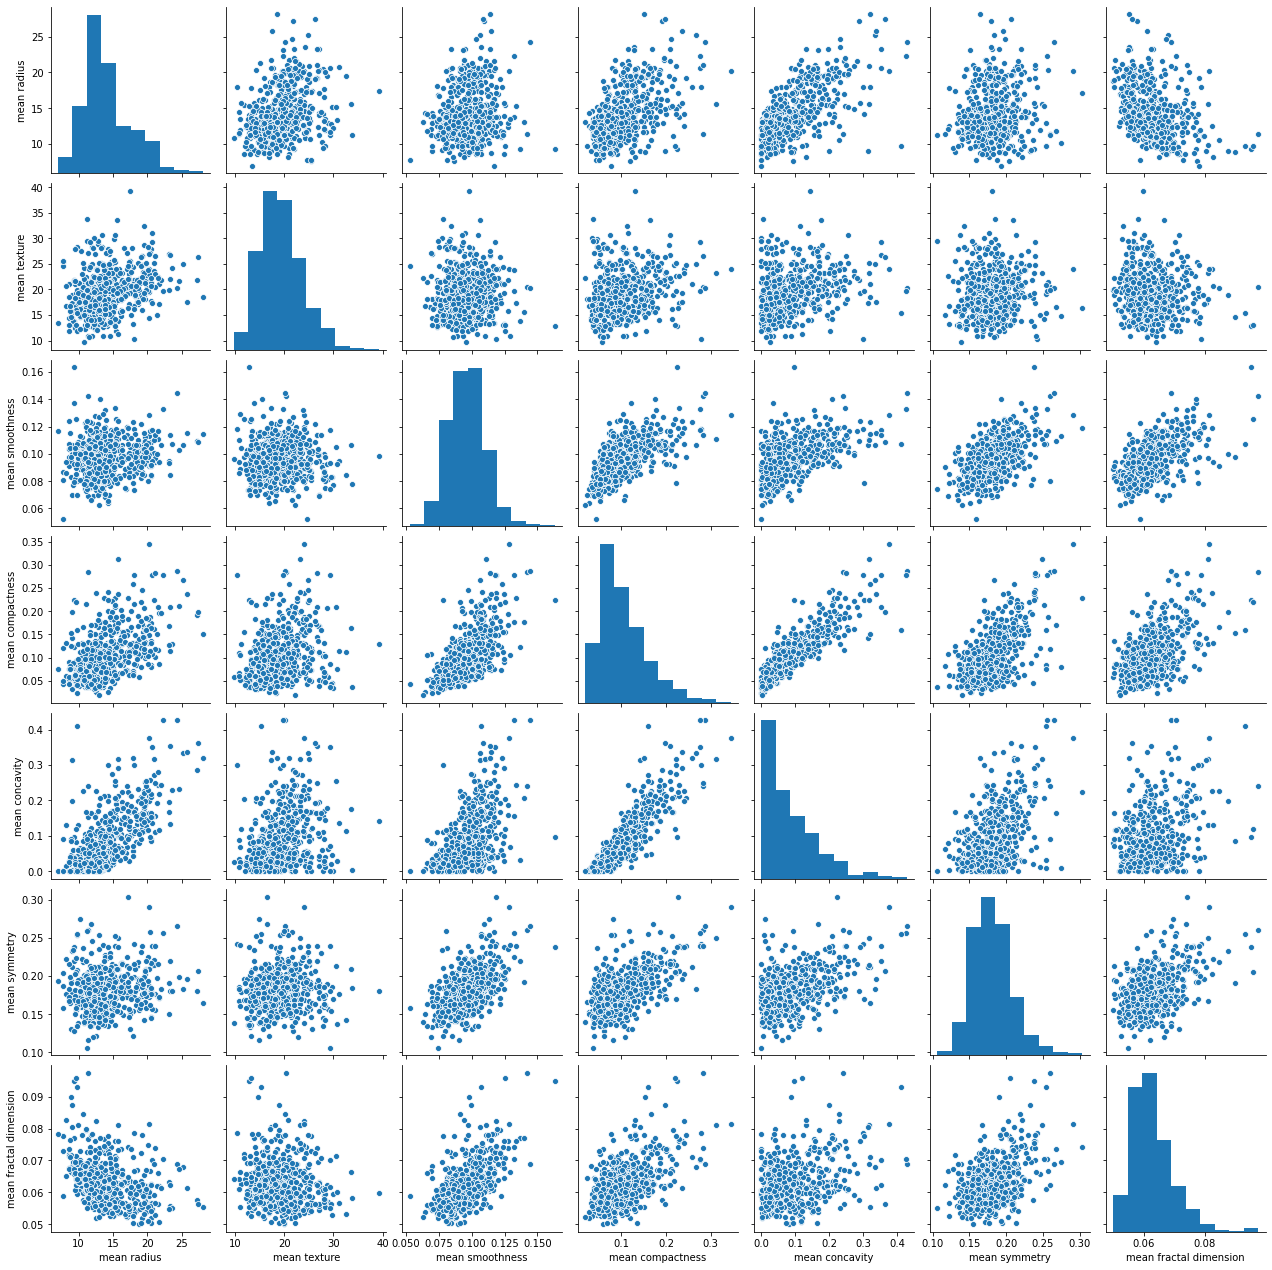

In [10]:
sns.pairplot(X)
#sns.pairplot(df)

Now we will merge labeled and unlabeled data.
The common practice (most libs will need it that way) is to label unlabeled data `-1`. Some libs will only accept `NaN` as label for unlabeled data. Always check documentation and user guides.

In [11]:
X_1, X_2, X_3  = np.split(X, [int(.1*len(X)), int(.5*len(X))])
y_1, y_2, y_3  = np.split(y, [int(.1*len(y)), int(.5*len(y))])
y_1_2 = np.concatenate((y_1, y_2.apply(lambda x: -1)))
X_1_2 = np.concatenate((X_1, X_2))

In [12]:
index = ['Algorithm', 'ROC AUC']
results = pd.DataFrame(columns=index)

In [13]:
logreg = LogisticRegression(random_state=1, class_weight='balanced')
logreg.fit(X_1, y_1)
results = results.append(pd.Series(['Logistic Regression', roc_auc_score(y_3, logreg.predict_proba(X_3)[:,1])], 
                                   index=index), ignore_index=True)
results

,Algorithm,ROC AUC
0,Logistic Regression,0.972269


Just for reference LR timings.

*Reminder: df is 569x31 dense matrix*

In [14]:
%%timeit
logreg_test = LogisticRegression(random_state=1, class_weight='balanced')
logreg_test.fit(df, y)
logreg_test.predict_proba(df);

27.2 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Label Propagation

Time to use our first SSL model - `LabelPropagation` (LP). It's quite simple. Intuitively, it looks and sounds like a clustering algorithm that just "propagate" labels to nearest data points. But we need to go a little bit deeper.

Y is our label matrix, it has size of $(l+u)\times C$, where l - amount of labeled data points, u - amount of unlabeled data points, C - number of classes. So in binary classification task we will get 2 columns. It's kind of list that we will get from `predict_proba` method.

The algorithm will create a fully connected graph where nodes are **all** the data points. The edges between nodes will be weights $w_{i,j}$: 

$$w_{i,j} = exp(\frac{d_{i,j}^2}{\sigma^2})$$

where *d* - distance function (euclidean in this case, but in general could be any distance function you want), $\sigma$ - hyperparameter, that control (shrink) weights.

Then we build probabilistic transition matrix T: 

$$T_{i,j} = \frac{w_{i,j}}{\sum_{k=1}^{l+u}w_{i,j}}$$

T is just a matrix with probability of every data point to be in class C. Our labeled data points has 1.0 probability to be in class C (since we know their classes) and unlabeled data will get their classes from neighbours (we calculated weights earlier, they depend on distance between 2 points).

The whole algorithm looks like this:
1. Propagate Y <- TY (we "propagate" labels from labeled data to unlabeled)
2. Row-normalize Y (value of element in row / sum of all elements values in row)
3. Clamp the labeled data (we fixinig our labeled data, so our algorithm won't change probability of class, or in another words change the label)
4. Repeat from step 1 until Y converges (we recalculate or distances and weights, that will give us different transition matrix that will change our belief in assigned labels, repeat until process converge).

In case of `sklearn` implementation we have a choice of weightening function: RBF (see formula for $w_{i,j}$) or KNN ($1(x' \in kNN(x))$). KNN is faster and gives sparse representation. RBF is harder to compute and store dense transition matrix in memory, but has more options for tuning. Also sklearn RBF implementation instead of dividing by $\sigma^2$ multiply it by `gamma`, so it should be float, not integer.

To learn more you can read [this](http://pages.cs.wisc.edu/~jerryzhu/pub/CMU-CALD-02-107.pdf) and [this](https://scikit-learn.org/stable/modules/label_propagation.html#label-propagation). `sklearn` also has some cool examples of `LabelPropagation`: [SVM vs LP](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_versus_svm_iris.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-versus-svm-iris-py), [LP demo](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-structure-py), [LP digits recognition](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-py) and [LP digits active learning](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-active-learning-py).

Now I will define a little function that will give us a plot of ROC AUC of our algorithm depending on our kernel and parameter list.

In [15]:
def label_prop_test(kernel, params_list, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0, 0
    roc_scores = []
    if kernel == 'rbf':
        for g in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=100000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:,1]))
    if kernel == 'knn':
        for n in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=100000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:,1]))
    plt.figure(figsize=(16,8));
    plt.plot(params_list, roc_scores)
    plt.title('Label Propagation ROC AUC with ' + kernel + ' kernel')
    plt.show()
    print('Best metrics value is at {}'.format(params_list[np.argmax(roc_scores)]))

<Figure size 1440x720 with 0 Axes>

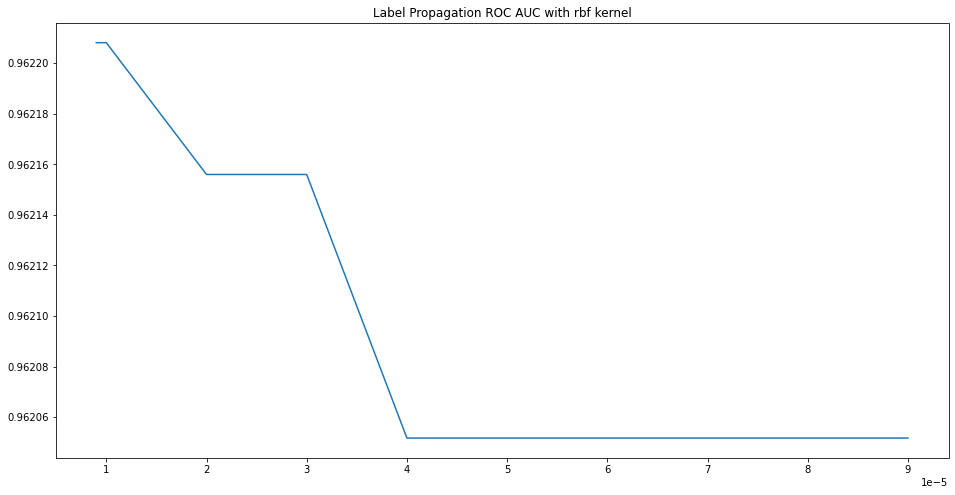

Best metrics value is at 9e-06


In [16]:
gammas = [9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5]
label_prop_test('rbf', gammas, X_1_2, X_3, y_1_2, y_3)

<Figure size 1440x720 with 0 Axes>

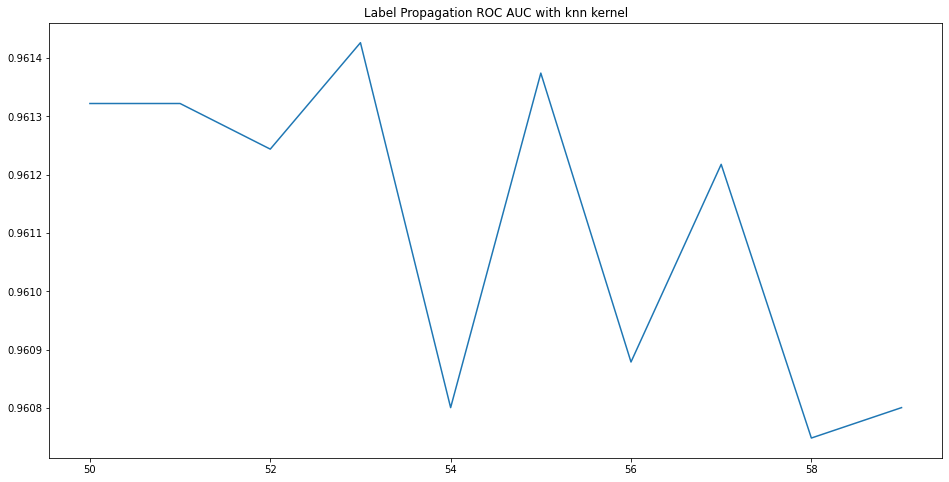

Best metrics value is at 53


In [17]:
ns = np.arange(50,60)
label_prop_test('knn', ns, X_1_2, X_3, y_1_2, y_3)

Now you can define your model separately with the best (or whatever) hyperparameter value and check its score

In [18]:
lp_rbf = LabelPropagation(kernel='rbf', gamma=9e-6, max_iter=100000, tol=0.0001)
lp_rbf.fit(X_1_2, y_1_2)
results = results.append(pd.Series(['Label Propagation RBF', 
                                    roc_auc_score(y_3, lp_rbf.predict_proba(X_3)[:,1])], index=index), ignore_index=True)

lp_knn = LabelPropagation(kernel='knn', n_neighbors=53, max_iter=100000, tol=0.0001)
lp_knn.fit(X_1_2, y_1_2)
results = results.append(pd.Series(['Label Propagation KNN', 
                                    roc_auc_score(y_3, lp_knn.predict_proba(X_3)[:,1])], index=index), ignore_index=True)

In [19]:
results

,Algorithm,ROC AUC
0,Logistic Regression,0.972269
1,Label Propagation RBF,0.962208
2,Label Propagation KNN,0.961426


Now let's talk about time. You can just look at the results or run command on your machine. On dense matrixes it's okeish, but on sparse representation it's a catastrophy (knn kernel is bareable). But for this we have [Sparse Label Propagation](https://arxiv.org/abs/1612.01414) or some dimensionality reduction technique (PCA, ICA, RCA etc.)

In [20]:
%%timeit
rbf_lp_test = LabelPropagation(kernel='rbf')
rbf_lp_test.fit(df, y)
rbf_lp_test.predict_proba(df);

38.3 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
knn_lp_test = LabelPropagation(kernel='knn')
knn_lp_test.fit(df, y)
knn_lp_test.predict_proba(df);

18.9 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

## Label Spreading

Next one is `LabelSpreading` (LS). The algorithm is very similar to spectral clustering algorithm *normalized cuts algorithm* ([look here](https://en.wikipedia.org/wiki/Spectral_clustering), [here](https://towardsdatascience.com/spectral-clustering-for-beginners-d08b7d25b4d8) and [here](https://papers.nips.cc/paper/2092-on-spectral-clustering-analysis-and-an-algorithm.pdf)).
LS will create a affinity matrix (same as LP weights calculation step): 

$$W_{i,j} = exp(\frac{-||x_i - x_j||^2}{\sigma^2})$$

for every $i\neq j$ and $W_{i,j} = 0$ for every $i = j$

Then we will construct the matrix (Laplacian):

$$S = D^{-1/2}WD^{−1/2}$$

where D - diagonal matrix with its *(i,i)*-element equal to the sum of the i-th row of W.

These two steps is just a spectral clustering on all our data. Next two is more interesting:
 
Iterate $F(t+1) = αSF(t)+(1−α)Y$ until convergence, where α is a parameter in (0, 1), F(t) - classifying function

Let $F^*$ denote the limit of the sequence {F(t)}. Label each point $x_i$ as a label $y_i = argmax≤F^*_{i,j}$

During each iteration of the third step each point receives the information from its neighbors (first term), and also retains its initial information (second term). The parameter α specifies the relative amount of the information from its neighbors and its initial label information. Finally, the label of each unlabeled point is set to be the class of which it has received most information during the iteration process.

You can read article about Label Spreading [here](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=19D11D059FCEDAFA443FB135B4065A6A?doi=10.1.1.115.3219&rep=rep1&type=pdf), `sklearn` user docs are [here](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html).

In [ ]:
def labels_spread_test(kernel, hyperparam, alphas, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0, 0
    roc_scores = []
    if kernel == 'rbf':
        g = hyperparam
    if kernel == 'knn':
        n = hyperparam
    for alpha in alphas:
        ls = LabelSpreading(kernel=kernel, n_neighbors=n, gamma=g, alpha=alpha, max_iter=1000, tol=0.001)
        ls.fit(X_train, y_train)
        roc_scores.append(roc_auc_score(y_test, ls.predict_proba(X_test)[:,1]))
    plt.figure(figsize=(16,8));
    plt.plot(alphas, roc_scores);
    plt.title('Label Spreading ROC AUC with ' + kernel + ' kernel')
    plt.show();
    print('Best metrics value is at {}'.format(alphas[np.argmax(roc_scores)]))

In [ ]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  
labels_spread_test('rbf', 1e-5, alphas, X_1_2, X_3, y_1_2, y_3)

In [ ]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]  
labels_spread_test('knn', 53, alphas, X_1_2, X_3, y_1_2, y_3)

In [ ]:
ls_rbf = LabelSpreading(kernel='rbf', gamma=9e-6, alpha=0.6, max_iter=1000, tol=0.001)
ls_rbf.fit(X_1_2, y_1_2)
results = results.append(pd.Series(['Label Spreading RBF', 
                                    roc_auc_score(y_3, ls_rbf.predict_proba(X_3)[:,1])], index=index), ignore_index=True)
ls_knn = LabelSpreading(kernel='knn', n_neighbors=53, alpha=0.08, max_iter=1000, tol=0.001)
ls_knn.fit(X_1_2, y_1_2)
results = results.append(pd.Series(['Label Spreading KNN', 
                                    roc_auc_score(y_3, ls_knn.predict_proba(X_3)[:,1])], index=index), ignore_index=True)

In [ ]:
results

And timings.

In [ ]:
%%timeit
knn_ls_test = LabelSpreading(kernel='rbf')
knn_ls_test.fit(df, y)
knn_ls_test.predict_proba(df);

In [ ]:
%%timeit
knn_ls_test = LabelSpreading(kernel='knn')
knn_ls_test.fit(df, y)
knn_ls_test.predict_proba(df);

## Naive Bayes

Now let us move to `pomegranate` lib. It supports SSL for some models: Naive Bayes, Bayes Classificator, Hidden Markov Models.
We will use only Naive Bayes (NB), it's plain and simple.

>Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features [[source]](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

<center><p><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/52bd0ca5938da89d7f9bf388dc7edcbd546c118e" title="NB explanation"/></p></center>

We will use [Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) for our predictions. So, we need to find $p(c|x)$ (probability of the class c given sample x). To do it we need to calculate $p(c)$ - just a class probability in general, $p(x)$ - our *evidence* and $p(x|c)$. The last one is very hard to compute since in general we need to take into account conditional dependencies in our data.

But what if we assume that all our features are conditionally independent given class c (very strong and mostly wrong assumption)? Well, this would make our life **a lot** easier.
We can now just calculate $p(c|x)$ as a product of $p(x_i|c)$.

<center><p><img src="https://www.saedsayad.com/images/Bayes_rule.png" title="NB explanation 2"/></p></center>

Img 3 - Naive Bayes explanation [[source]](https://www.saedsayad.com/images/Bayes_rule.png)

For every sample we will pick the most probable class (this is known as the maximum a posteriori or MAP decision rule). Then we can write down our optimization task

<center><p><img src="https://cdn-images-1.medium.com/max/800/1*0izKZvefo1pCCVXK3fmLhg.png" title="NB optimization"/></p></center>

Img 4 - Naive Bayes classifier [[source]](https://towardsdatascience.com/introduction-to-naive-bayes-classification-4cffabb1ae54)

Another assumption that Naive Bayes make use of is equality of all our features. It's wrong too, but with it we don't need to set weights to our features. Although some libs give you that possibility.

There a lot of articles about NB, I like this [one](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html) and [wiki's one](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).
`pomegranate` bayes classifier user docs are [here](https://pomegranate.readthedocs.io/en/latest/NaiveBayes.html)

Now we will initiate our NB model directly from our data. `from_samples` is the method that allow us to do it and set distribution that will model our data.
Another way is to directly pre-initialize distributions and its parameters and then just predict samples classes.
Here I picked `ExponentialDistribution` but you can pick whatever you want. The list of supported distributions is [here](https://pomegranate.readthedocs.io/en/latest/Distributions.html). The ones you want here are: `ExponentialDistribution`, `NormalDistribution`, `PoissonDistribution`. You can check others but it will give you an error since algorithm won't converge.

In [ ]:
nb = pg.NaiveBayes.from_samples(pg.ExponentialDistribution, X_1_2, y_1_2, verbose=True)
roc_auc_score(y_3, nb.predict_proba(X_3)[:,1])

Close to random. FeelsBad. Let's try some crazy things. We will construct our independent component distribution with n-dimensions (in this case 7). We will cheat a bit, since we already now how our data is distributed (see `sns.pairplot` step). My take on this is below

In [ ]:
d = [pg.ExponentialDistribution, pg.PoissonDistribution, pg.NormalDistribution, 
     pg.ExponentialDistribution, pg.ExponentialDistribution, pg.PoissonDistribution, pg.NormalDistribution]
nb = pg.NaiveBayes.from_samples(d, X_1_2, y_1_2, verbose=True)
results = results.append(pd.Series(['Naive Bayes ICD Prior', 
                                    roc_auc_score(y_3, nb.predict_proba(X_3)[:,1])], index=index), ignore_index=True)

In [ ]:
results

It's still bad since our data is correlated and not equal at all. At least our `logreg` doesn't think so.
But still NB is could be useful in some cases since it's simple, **very** fast and has interpretability. You can use it as a baseline or as "scouting" algorithm.

In [ ]:
logReg_coeff = pd.DataFrame({'feature_name': list(X.columns.values), 
                             'model_coefficient': logreg.coef_.transpose().flatten()});
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False);

fg = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff);
fg.set_xticklabels(rotation=35, labels=logReg_coeff['feature_name']);

Last but not least - timings

In [ ]:
%%timeit
nb_test = pg.NaiveBayes.from_samples(pg.ExponentialDistribution, df, y, verbose=False)
nb_test.predict_proba(df);

## Bonus

And the last one, but not the least. Pseudo-Labeling. I won't copy-paste it, you can do it yourself. This is very simple approach. We will just separate our labeled and unlabeled data, train model on labelled. Then we will sample unlabeled data and predict these samples and add them to labeled data as new ground truth. That's it.
You can literally use everything with it: regression models or classification models. In fact original it was designed for neural nets, but it is very versatile.

<center><p><img src="https://datawhatnow.com/wp-content/uploads/2017/08/pseudo-labeling-683x1024.png" title="Pseudo-Labeling"/></p></center>

Img 5 - Pseudo-Labeling explanation [[source]](https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/)

Pseudo-Labeling described [here](https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/) with code and graphs, [copypaste on another blog](https://www.analyticsvidhya.com/blog/2017/09/pseudo-labelling-semi-supervised-learning-technique/).
Original article is [here](http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf)
You can copy it below and play with it!